In [1]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


Using TensorFlow backend.


In [2]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [3]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [4]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    months_df = pd.get_dummies(join.index.month, prefix='month')
    months_df.index=join.index
    join = pd.concat([join, months_df], axis=1)
    reactor_list.append(join)

In [5]:
reactor_list[0]

,SVI,Temperature,F_M - A,Sludge Age - A,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,
2010-01-01,90.943683,22.030,0.23,3.44,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-02,84.365325,21.985,0.18,3.78,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-03,94.541139,21.740,0.21,3.82,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-04,97.402597,21.815,0.21,3.40,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-05,107.937685,21.890,0.23,3.70,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,166.666667,22.540,0.25,2.75,0,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,147.453083,22.535,0.26,2.91,0,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,154.702970,22.660,0.26,2.82,0,0,0,0,0,0,0,0,0,0,0,1


In [6]:
X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=2, binary=True)

In [7]:
X.shape

(16064, 2, 16)

In [8]:
X[0]

array([[90.94368341, 22.03      ,  0.23      ,  3.44      ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [84.36532508, 21.985     ,  0.18      ,  3.78      ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [9]:
Y[0]

array([1.])

In [10]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=30, batch_size=10, shuffle=True)


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 139.43it/s]


Epoch 1/30
14457/14457 [==============================] - 13s 909us/step - loss: 0.4393 - binary_accuracy: 0.7780
Epoch 2/30
14457/14457 [==============================] - 12s 840us/step - loss: 0.3546 - binary_accuracy: 0.8188
Epoch 3/30
14457/14457 [==============================] - 12s 835us/step - loss: 0.3488 - binary_accuracy: 0.82982s -
Epoch 4/30
14457/14457 [==============================] - 12s 798us/step - loss: 0.3435 - binary_accuracy: 0.8342
Epoch 5/30
14457/14457 [==============================] - 11s 787us/step - loss: 0.3401 - binary_accuracy: 0.8380
Epoch 6/30
14457/14457 [==============================] - 12s 797us/step - loss: 0.3388 - binary_accuracy: 0.8407
Epoch 7/30
14457/14457 [==============================] - 11s 758us/step - loss: 0.3398 - binary_accuracy: 0.8422
Epoch 8/30
14457/14457 [==============================] - 7s 457us/step - loss: 0.3375 - binary_accuracy: 0.8436
Epoch 9/30
14457/14457 [==============================] - 10s 680us/step - loss: 0.33

In [11]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)

In [12]:
threshold = 0.5
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
y_real = Ytest.astype(int)

In [13]:
classes = ['High_svi', 'Low_svi']

In [14]:
cm = confusion_matrix(y_real, y_predict)

Confusion matrix, without normalization
[[ 206  174]
 [  76 1151]]


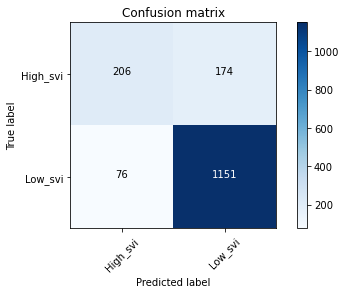

In [15]:
sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [16]:
results = km.results(y_real, y_predict, binary=True)

In [17]:
results

(0.8444306160547604, 0.5421052631578948, 0.7304964539007093, 0.622356495468278)

In [18]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [19]:
auc(fpr, tpr)

0.8843971174880967

Text(0.5, 1.0, 'ROC curve')

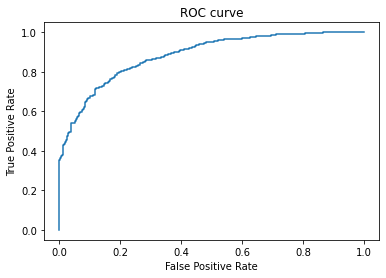

In [21]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [22]:
results_list = []
for i in range (1,11):
    for j in range (1, 11):
        X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
        X_normalize, Y_normalize, scalers = km.normalize(X, Y)
        Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
        model.fit(Xtrain, ytrain, epochs=30, batch_size=10, shuffle=True)
        Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
        y_predict = np.rint(Yhat).astype(int)
        y_real = Ytest.astype(int)
        results_list.append(km.results(y_real, y_predict))
    


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.16it/s]


Epoch 1/30
12854/12854 [==============================] - 9s 683us/step - loss: 0.5893
Epoch 2/30
12854/12854 [==============================] - 8s 635us/step - loss: 0.5345
Epoch 3/30
12854/12854 [==============================] - 8s 629us/step - loss: 0.5212
Epoch 4/30
12854/12854 [==============================] - 8s 645us/step - loss: 0.5025
Epoch 5/30
12854/12854 [==============================] - 9s 670us/step - loss: 0.4773
Epoch 6/30
12854/12854 [==============================] - 7s 579us/step - loss: 0.4480
Epoch 7/30
12854/12854 [==============================] - 5s 364us/step - loss: 0.4202
Epoch 8/30
12854/12854 [==============================] - 6s 428us/step - loss: 0.3977
Epoch 9/30
12854/12854 [==============================] - 8s 640us/step - loss: 0.3824
Epoch 10/30
12854/12854 [==============================] - 8s 604us/step - loss: 0.3724
Epoch 11/30
12854/12854 [==============================] - 8s 657us/step - loss: 0.3667
Epoch 12/30
12854/12854 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.35it/s]


Epoch 1/30
12851/12851 [==============================] - 9s 730us/step - loss: 0.5846
Epoch 2/30
12851/12851 [==============================] - 8s 642us/step - loss: 0.5354
Epoch 3/30
12851/12851 [==============================] - 8s 620us/step - loss: 0.5222
Epoch 4/30
12851/12851 [==============================] - 8s 628us/step - loss: 0.5046
Epoch 5/30
12851/12851 [==============================] - 8s 633us/step - loss: 0.4847
Epoch 6/30
12851/12851 [==============================] - 7s 547us/step - loss: 0.4624
Epoch 7/30
12851/12851 [==============================] - 5s 381us/step - loss: 0.4419
Epoch 8/30
12851/12851 [==============================] - 8s 600us/step - loss: 0.4239
Epoch 9/30
12851/12851 [==============================] - 9s 662us/step - loss: 0.4104
Epoch 10/30
12851/12851 [==============================] - 8s 621us/step - loss: 0.4009
Epoch 11/30
12851/12851 [==============================] - 8s 594us/step - loss: 0.3946
Epoch 12/30
12851/12851 [================

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 97.87it/s]


Epoch 1/30
12848/12848 [==============================] - 9s 723us/step - loss: 0.5969
Epoch 2/30
12848/12848 [==============================] - 8s 639us/step - loss: 0.5334
Epoch 3/30
12848/12848 [==============================] - 8s 639us/step - loss: 0.5214
Epoch 4/30
12848/12848 [==============================] - 8s 589us/step - loss: 0.5049
Epoch 5/30
12848/12848 [==============================] - 8s 636us/step - loss: 0.4848
Epoch 6/30
12848/12848 [==============================] - 4s 309us/step - loss: 0.4637
Epoch 7/30
12848/12848 [==============================] - 5s 390us/step - loss: 0.4446
Epoch 8/30
12848/12848 [==============================] - 8s 638us/step - loss: 0.4294
Epoch 9/30
12848/12848 [==============================] - 8s 638us/step - loss: 0.4179
Epoch 10/30
12848/12848 [==============================] - 8s 630us/step - loss: 0.4101
Epoch 11/30
12848/12848 [==============================] - 8s 635us/step - loss: 0.4049
Epoch 12/30
12848/12848 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 210.25it/s]


Epoch 1/30
12844/12844 [==============================] - 7s 552us/step - loss: 0.5827
Epoch 2/30
12844/12844 [==============================] - 8s 656us/step - loss: 0.5358
Epoch 3/30
12844/12844 [==============================] - 8s 647us/step - loss: 0.5264
Epoch 4/30
12844/12844 [==============================] - 8s 649us/step - loss: 0.5149
Epoch 5/30
12844/12844 [==============================] - 7s 512us/step - loss: 0.5002
Epoch 6/30
12844/12844 [==============================] - 7s 565us/step - loss: 0.4819
Epoch 7/30
12844/12844 [==============================] - 7s 563us/step - loss: 0.4635
Epoch 8/30
12844/12844 [==============================] - 4s 347us/step - loss: 0.4464
Epoch 9/30
12844/12844 [==============================] - 5s 420us/step - loss: 0.4335
Epoch 10/30
12844/12844 [==============================] - 8s 662us/step - loss: 0.4248
Epoch 11/30
12844/12844 [==============================] - 7s 581us/step - loss: 0.4188
Epoch 12/30
12844/12844 [================

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.05it/s]


Epoch 1/30
12841/12841 [==============================] - 4s 334us/step - loss: 0.5754
Epoch 2/30
12841/12841 [==============================] - 8s 626us/step - loss: 0.5298
Epoch 3/30
12841/12841 [==============================] - 8s 622us/step - loss: 0.5200
Epoch 4/30
12841/12841 [==============================] - 8s 621us/step - loss: 0.5073
Epoch 5/30
12841/12841 [==============================] - 8s 622us/step - loss: 0.4926
Epoch 6/30
12841/12841 [==============================] - 8s 625us/step - loss: 0.4762
Epoch 7/30
12841/12841 [==============================] - 8s 622us/step - loss: 0.4589
Epoch 8/30
12841/12841 [==============================] - 8s 624us/step - loss: 0.4443
Epoch 9/30
12841/12841 [==============================] - 8s 645us/step - loss: 0.4330
Epoch 10/30
12841/12841 [==============================] - 4s 344us/step - loss: 0.4248
Epoch 11/30
12841/12841 [==============================] - 5s 420us/step - loss: 0.4191
Epoch 12/30
12841/12841 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 105.56it/s]


Epoch 1/30
12838/12838 [==============================] - 11s 882us/step - loss: 0.5891
Epoch 2/30
12838/12838 [==============================] - 9s 700us/step - loss: 0.5306
Epoch 3/30
12838/12838 [==============================] - 10s 814us/step - loss: 0.5202
Epoch 4/30
12838/12838 [==============================] - 11s 819us/step - loss: 0.5075
Epoch 5/30
12838/12838 [==============================] - 10s 808us/step - loss: 0.4932
Epoch 6/30
12838/12838 [==============================] - 10s 818us/step - loss: 0.4777
Epoch 7/30
12838/12838 [==============================] - 11s 826us/step - loss: 0.4630
Epoch 8/30
12838/12838 [==============================] - 10s 781us/step - loss: 0.4499
Epoch 9/30
12838/12838 [==============================] - 7s 567us/step - loss: 0.4397
Epoch 10/30
12838/12838 [==============================] - 10s 755us/step - loss: 0.4317
Epoch 11/30
12838/12838 [==============================] - 11s 826us/step - loss: 0.4262
Epoch 12/30
12838/12838 [=======

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 220.73it/s]


Epoch 1/30
12835/12835 [==============================] - 10s 802us/step - loss: 0.5822
Epoch 2/30
12835/12835 [==============================] - 10s 746us/step - loss: 0.5325
Epoch 3/30
12835/12835 [==============================] - 10s 748us/step - loss: 0.5229
Epoch 4/30
12835/12835 [==============================] - 10s 746us/step - loss: 0.5126
Epoch 5/30
12835/12835 [==============================] - 10s 742us/step - loss: 0.4988
Epoch 6/30
12835/12835 [==============================] - 10s 753us/step - loss: 0.4820
Epoch 7/30
12835/12835 [==============================] - 10s 742us/step - loss: 0.4664
Epoch 8/30
12835/12835 [==============================] - 10s 742us/step - loss: 0.4537
Epoch 9/30
12835/12835 [==============================] - 9s 740us/step - loss: 0.4438
Epoch 10/30
12835/12835 [==============================] - 10s 744us/step - loss: 0.4361
Epoch 11/30
12835/12835 [==============================] - 8s 652us/step - loss: 0.4311
Epoch 12/30
12835/12835 [=======

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 94.04it/s]


Epoch 1/30
12832/12832 [==============================] - 10s 766us/step - loss: 0.5928
Epoch 2/30
12832/12832 [==============================] - 10s 777us/step - loss: 0.5379
Epoch 3/30
12832/12832 [==============================] - 10s 753us/step - loss: 0.5311
Epoch 4/30
12832/12832 [==============================] - 10s 745us/step - loss: 0.5225
Epoch 5/30
12832/12832 [==============================] - 10s 751us/step - loss: 0.5117
Epoch 6/30
12832/12832 [==============================] - 10s 761us/step - loss: 0.4998
Epoch 7/30
12832/12832 [==============================] - 9s 723us/step - loss: 0.4871
Epoch 8/30
12832/12832 [==============================] - 7s 540us/step - loss: 0.4748
Epoch 9/30
12832/12832 [==============================] - 10s 751us/step - loss: 0.4643
Epoch 10/30
12832/12832 [==============================] - 9s 734us/step - loss: 0.4559
Epoch 11/30
12832/12832 [==============================] - 8s 621us/step - loss: 0.4496
Epoch 12/30
12832/12832 [=========

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.82it/s]


Epoch 1/30
12828/12828 [==============================] - 9s 691us/step - loss: 0.5919
Epoch 2/30
12828/12828 [==============================] - 9s 676us/step - loss: 0.5413
Epoch 3/30
12828/12828 [==============================] - 8s 629us/step - loss: 0.5348
Epoch 4/30
12828/12828 [==============================] - 7s 563us/step - loss: 0.5278
Epoch 5/30
12828/12828 [==============================] - 9s 685us/step - loss: 0.5190
Epoch 6/30
12828/12828 [==============================] - 9s 685us/step - loss: 0.5094
Epoch 7/30
12828/12828 [==============================] - 8s 651us/step - loss: 0.4982
Epoch 8/30
12828/12828 [==============================] - 7s 546us/step - loss: 0.4865
Epoch 9/30
12828/12828 [==============================] - 8s 591us/step - loss: 0.4758
Epoch 10/30
12828/12828 [==============================] - 8s 594us/step - loss: 0.4669
Epoch 11/30
12828/12828 [==============================] - 8s 594us/step - loss: 0.4600
Epoch 12/30
12828/12828 [================

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.98it/s]


Epoch 1/30
12825/12825 [==============================] - 8s 631us/step - loss: 0.5923
Epoch 2/30
12825/12825 [==============================] - 6s 479us/step - loss: 0.5388
Epoch 3/30
12825/12825 [==============================] - 7s 552us/step - loss: 0.5319
Epoch 4/30
12825/12825 [==============================] - 8s 596us/step - loss: 0.5246
Epoch 5/30
12825/12825 [==============================] - 8s 604us/step - loss: 0.5164
Epoch 6/30
12825/12825 [==============================] - 7s 536us/step - loss: 0.5067
Epoch 7/30
12825/12825 [==============================] - 7s 570us/step - loss: 0.4970
Epoch 8/30
12825/12825 [==============================] - 6s 507us/step - loss: 0.4872
Epoch 9/30
12825/12825 [==============================] - 10s 809us/step - loss: 0.4785
Epoch 10/30
12825/12825 [==============================] - 12s 920us/step - loss: 0.4710
Epoch 11/30
12825/12825 [==============================] - 12s 936us/step - loss: 0.4647
Epoch 12/30
12825/12825 [=============

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 64.51it/s]


Epoch 1/30
12851/12851 [==============================] - 13s 994us/step - loss: 0.5663
Epoch 2/30
12851/12851 [==============================] - 11s 876us/step - loss: 0.5226
Epoch 3/30
12851/12851 [==============================] - 9s 714us/step - loss: 0.4887
Epoch 4/30
12851/12851 [==============================] - 6s 438us/step - loss: 0.4375
Epoch 5/30
12851/12851 [==============================] - 5s 414us/step - loss: 0.3939
Epoch 6/30
12851/12851 [==============================] - 7s 512us/step - loss: 0.3721
Epoch 7/30
12851/12851 [==============================] - 6s 445us/step - loss: 0.3635
Epoch 8/30
12851/12851 [==============================] - 6s 450us/step - loss: 0.3592
Epoch 9/30
12851/12851 [==============================] - 8s 646us/step - loss: 0.3577
Epoch 10/30
12851/12851 [==============================] - 5s 423us/step - loss: 0.3546
Epoch 11/30
12851/12851 [==============================] - 6s 458us/step - loss: 0.3523
Epoch 12/30
12851/12851 [==============

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 63.27it/s]


Epoch 1/30
12848/12848 [==============================] - 10s 785us/step - loss: 0.5768
Epoch 2/30
12848/12848 [==============================] - 9s 716us/step - loss: 0.5283
Epoch 3/30
12848/12848 [==============================] - 8s 644us/step - loss: 0.5074
Epoch 4/30
12848/12848 [==============================] - 8s 602us/step - loss: 0.4683
Epoch 5/30
12848/12848 [==============================] - 9s 692us/step - loss: 0.4244
Epoch 6/30
12848/12848 [==============================] - 9s 680us/step - loss: 0.3960
Epoch 7/30
12848/12848 [==============================] - 8s 613us/step - loss: 0.3839
Epoch 8/30
12848/12848 [==============================] - 9s 673us/step - loss: 0.3805
Epoch 9/30
12848/12848 [==============================] - 9s 673us/step - loss: 0.3758
Epoch 10/30
12848/12848 [==============================] - 7s 557us/step - loss: 0.3742
Epoch 11/30
12848/12848 [==============================] - 6s 498us/step - loss: 0.3722
Epoch 12/30
12848/12848 [===============

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 64.14it/s]


Epoch 1/30
12844/12844 [==============================] - 12s 915us/step - loss: 0.5743
Epoch 2/30
12844/12844 [==============================] - 7s 534us/step - loss: 0.5295
Epoch 3/30
12844/12844 [==============================] - 9s 733us/step - loss: 0.5082
Epoch 4/30
12844/12844 [==============================] - 9s 734us/step - loss: 0.4696
Epoch 5/30
12844/12844 [==============================] - 9s 737us/step - loss: 0.4309
Epoch 6/30
12844/12844 [==============================] - 8s 641us/step - loss: 0.4085
Epoch 7/30
12844/12844 [==============================] - 9s 735us/step - loss: 0.3975
Epoch 8/30
12844/12844 [==============================] - 9s 688us/step - loss: 0.3921
Epoch 9/30
12844/12844 [==============================] - 7s 564us/step - loss: 0.3911
Epoch 10/30
12844/12844 [==============================] - 9s 737us/step - loss: 0.3891
Epoch 11/30
12844/12844 [==============================] - 9s 737us/step - loss: 0.3855
Epoch 12/30
12844/12844 [===============

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 62.89it/s]


Epoch 1/30
12841/12841 [==============================] - 8s 599us/step - loss: 0.5743
Epoch 2/30
12841/12841 [==============================] - 7s 559us/step - loss: 0.5209
Epoch 3/30
12841/12841 [==============================] - 7s 552us/step - loss: 0.5033 0s - loss
Epoch 4/30
12841/12841 [==============================] - 8s 615us/step - loss: 0.4752
Epoch 5/30
12841/12841 [==============================] - 8s 617us/step - loss: 0.4434
Epoch 6/30
12841/12841 [==============================] - 8s 609us/step - loss: 0.4197
Epoch 7/30
12841/12841 [==============================] - 8s 616us/step - loss: 0.4064
Epoch 8/30
12841/12841 [==============================] - 8s 620us/step - loss: 0.3997
Epoch 9/30
12841/12841 [==============================] - 8s 617us/step - loss: 0.3974
Epoch 10/30
12841/12841 [==============================] - 8s 609us/step - loss: 0.3962
Epoch 11/30
12841/12841 [==============================] - 8s 614us/step - loss: 0.3937
Epoch 12/30
12841/12841 [======

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 68.14it/s]


Epoch 1/30
12838/12838 [==============================] - 11s 870us/step - loss: 0.5618
Epoch 2/30
12838/12838 [==============================] - 11s 824us/step - loss: 0.5211
Epoch 3/30
12838/12838 [==============================] - 11s 830us/step - loss: 0.5043
Epoch 4/30
12838/12838 [==============================] - 10s 746us/step - loss: 0.4741
Epoch 5/30
12838/12838 [==============================] - 5s 409us/step - loss: 0.4397
Epoch 6/30
12838/12838 [==============================] - 10s 750us/step - loss: 0.4174
Epoch 7/30
12838/12838 [==============================] - 10s 766us/step - loss: 0.4075
Epoch 8/30
12838/12838 [==============================] - 10s 783us/step - loss: 0.4035
Epoch 9/30
12838/12838 [==============================] - 9s 664us/step - loss: 0.4013
Epoch 10/30
12838/12838 [==============================] - 5s 413us/step - loss: 0.3997
Epoch 11/30
12838/12838 [==============================] - 6s 438us/step - loss: 0.3968
Epoch 12/30
12838/12838 [=========

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 104.60it/s]


Epoch 1/30
12835/12835 [==============================] - 12s 958us/step - loss: 0.5738
Epoch 2/30
12835/12835 [==============================] - 8s 595us/step - loss: 0.5266
Epoch 3/30
12835/12835 [==============================] - 6s 464us/step - loss: 0.5132
Epoch 4/30
12835/12835 [==============================] - 7s 533us/step - loss: 0.4952
Epoch 5/30
12835/12835 [==============================] - 5s 417us/step - loss: 0.4710
Epoch 6/30
12835/12835 [==============================] - 6s 438us/step - loss: 0.4466
Epoch 7/30
12835/12835 [==============================] - 7s 518us/step - loss: 0.4298
Epoch 8/30
12835/12835 [==============================] - 6s 468us/step - loss: 0.4182
Epoch 9/30
12835/12835 [==============================] - 7s 524us/step - loss: 0.4114
Epoch 10/30
12835/12835 [==============================] - 9s 699us/step - loss: 0.4087
Epoch 11/30
12835/12835 [==============================] - 5s 414us/step - loss: 0.4066
Epoch 12/30
12835/12835 [===============

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 67.42it/s]


Epoch 1/30
12832/12832 [==============================] - 19s 1ms/step - loss: 0.5753
Epoch 2/30
12832/12832 [==============================] - 7s 567us/step - loss: 0.5315
Epoch 3/30
12832/12832 [==============================] - 5s 400us/step - loss: 0.5178
Epoch 4/30
12832/12832 [==============================] - 5s 415us/step - loss: 0.4942
Epoch 5/30
12832/12832 [==============================] - 9s 689us/step - loss: 0.4657
Epoch 6/30
12832/12832 [==============================] - 10s 785us/step - loss: 0.4443
Epoch 7/30
12832/12832 [==============================] - 12s 921us/step - loss: 0.4339
Epoch 8/30
12832/12832 [==============================] - 9s 667us/step - loss: 0.4286
Epoch 9/30
12832/12832 [==============================] - 8s 601us/step - loss: 0.4244
Epoch 10/30
12832/12832 [==============================] - 3s 260us/step - loss: 0.4225
Epoch 11/30
12832/12832 [==============================] - 4s 296us/step - loss: 0.4216
Epoch 12/30
12832/12832 [===============

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.50it/s]


Epoch 1/30
12828/12828 [==============================] - 3s 215us/step - loss: 0.5811
Epoch 2/30
12828/12828 [==============================] - 3s 206us/step - loss: 0.5319
Epoch 3/30
12828/12828 [==============================] - 3s 197us/step - loss: 0.5180
Epoch 4/30
12828/12828 [==============================] - 2s 169us/step - loss: 0.4988
Epoch 5/30
12828/12828 [==============================] - 3s 249us/step - loss: 0.4754
Epoch 6/30
12828/12828 [==============================] - 3s 225us/step - loss: 0.4555
Epoch 7/30
12828/12828 [==============================] - 2s 189us/step - loss: 0.4445
Epoch 8/30
12828/12828 [==============================] - 3s 195us/step - loss: 0.4374
Epoch 9/30
12828/12828 [==============================] - 3s 210us/step - loss: 0.4349
Epoch 10/30
12828/12828 [==============================] - 3s 215us/step - loss: 0.4320
Epoch 11/30
12828/12828 [==============================] - 2s 191us/step - loss: 0.4307
Epoch 12/30
12828/12828 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 201.16it/s]


Epoch 1/30
12825/12825 [==============================] - 4s 280us/step - loss: 0.5653
Epoch 2/30
12825/12825 [==============================] - 3s 252us/step - loss: 0.5278
Epoch 3/30
12825/12825 [==============================] - 3s 234us/step - loss: 0.5106
Epoch 4/30
12825/12825 [==============================] - 3s 236us/step - loss: 0.4912
Epoch 5/30
12825/12825 [==============================] - 3s 240us/step - loss: 0.4732
Epoch 6/30
12825/12825 [==============================] - 3s 264us/step - loss: 0.4580
Epoch 7/30
12825/12825 [==============================] - 4s 305us/step - loss: 0.4482
Epoch 8/30
12825/12825 [==============================] - 4s 288us/step - loss: 0.4428
Epoch 9/30
12825/12825 [==============================] - 4s 281us/step - loss: 0.4383
Epoch 10/30
12825/12825 [==============================] - 3s 265us/step - loss: 0.4361
Epoch 11/30
12825/12825 [==============================] - 3s 264us/step - loss: 0.4347
Epoch 12/30
12825/12825 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.49it/s]


Epoch 1/30
12822/12822 [==============================] - 4s 295us/step - loss: 0.5798
Epoch 2/30
12822/12822 [==============================] - 3s 267us/step - loss: 0.5366
Epoch 3/30
12822/12822 [==============================] - 4s 276us/step - loss: 0.5270
Epoch 4/30
12822/12822 [==============================] - 3s 264us/step - loss: 0.5141
Epoch 5/30
12822/12822 [==============================] - 3s 257us/step - loss: 0.4956
Epoch 6/30
12822/12822 [==============================] - 3s 266us/step - loss: 0.4753
Epoch 7/30
12822/12822 [==============================] - 3s 268us/step - loss: 0.4595
Epoch 8/30
12822/12822 [==============================] - 3s 259us/step - loss: 0.4515
Epoch 9/30
12822/12822 [==============================] - 3s 258us/step - loss: 0.4472
Epoch 10/30
12822/12822 [==============================] - 3s 257us/step - loss: 0.4445
Epoch 11/30
12822/12822 [==============================] - 3s 266us/step - loss: 0.4432
Epoch 12/30
12822/12822 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.96it/s]


Epoch 1/30
12848/12848 [==============================] - 5s 410us/step - loss: 0.5619
Epoch 2/30
12848/12848 [==============================] - 4s 332us/step - loss: 0.5159
Epoch 3/30
12848/12848 [==============================] - 4s 310us/step - loss: 0.4609
Epoch 4/30
12848/12848 [==============================] - 4s 291us/step - loss: 0.3982
Epoch 5/30
12848/12848 [==============================] - 4s 280us/step - loss: 0.3749
Epoch 6/30
12848/12848 [==============================] - 4s 292us/step - loss: 0.3684
Epoch 7/30
12848/12848 [==============================] - 4s 297us/step - loss: 0.3632
Epoch 8/30
12848/12848 [==============================] - 4s 317us/step - loss: 0.3611
Epoch 9/30
12848/12848 [==============================] - 5s 381us/step - loss: 0.3584
Epoch 10/30
12848/12848 [==============================] - 4s 321us/step - loss: 0.3568
Epoch 11/30
12848/12848 [==============================] - 4s 303us/step - loss: 0.3536
Epoch 12/30
12848/12848 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.93it/s]


Epoch 1/30
12844/12844 [==============================] - 3s 271us/step - loss: 0.5686
Epoch 2/30
12844/12844 [==============================] - 3s 251us/step - loss: 0.5248
Epoch 3/30
12844/12844 [==============================] - 3s 258us/step - loss: 0.4937
Epoch 4/30
12844/12844 [==============================] - 4s 300us/step - loss: 0.4479
Epoch 5/30
12844/12844 [==============================] - 4s 322us/step - loss: 0.4103
Epoch 6/30
12844/12844 [==============================] - 4s 339us/step - loss: 0.3943
Epoch 7/30
12844/12844 [==============================] - 4s 336us/step - loss: 0.3906
Epoch 8/30
12844/12844 [==============================] - 4s 322us/step - loss: 0.3851
Epoch 9/30
12844/12844 [==============================] - 4s 320us/step - loss: 0.3810
Epoch 10/30
12844/12844 [==============================] - 4s 322us/step - loss: 0.3787
Epoch 11/30
12844/12844 [==============================] - 4s 309us/step - loss: 0.3771
Epoch 12/30
12844/12844 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 200.50it/s]


Epoch 1/30
12841/12841 [==============================] - 3s 242us/step - loss: 0.5720
Epoch 2/30
12841/12841 [==============================] - 3s 223us/step - loss: 0.5189
Epoch 3/30
12841/12841 [==============================] - 3s 218us/step - loss: 0.4915
Epoch 4/30
12841/12841 [==============================] - 3s 224us/step - loss: 0.4464
Epoch 5/30
12841/12841 [==============================] - 4s 301us/step - loss: 0.4107
Epoch 6/30
12841/12841 [==============================] - 4s 325us/step - loss: 0.3974
Epoch 7/30
12841/12841 [==============================] - 4s 311us/step - loss: 0.3894
Epoch 8/30
12841/12841 [==============================] - 4s 288us/step - loss: 0.3899
Epoch 9/30
12841/12841 [==============================] - 4s 319us/step - loss: 0.3829
Epoch 10/30
12841/12841 [==============================] - 4s 281us/step - loss: 0.3834
Epoch 11/30
12841/12841 [==============================] - 3s 263us/step - loss: 0.3807
Epoch 12/30
12841/12841 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 214.69it/s]


Epoch 1/30
12838/12838 [==============================] - 4s 320us/step - loss: 0.5642
Epoch 2/30
12838/12838 [==============================] - 4s 292us/step - loss: 0.5158
Epoch 3/30
12838/12838 [==============================] - 4s 306us/step - loss: 0.4731
Epoch 4/30
12838/12838 [==============================] - 4s 308us/step - loss: 0.4202
Epoch 5/30
12838/12838 [==============================] - 4s 279us/step - loss: 0.4008
Epoch 6/30
12838/12838 [==============================] - 4s 295us/step - loss: 0.3962
Epoch 7/30
12838/12838 [==============================] - 5s 370us/step - loss: 0.3921
Epoch 8/30
12838/12838 [==============================] - 6s 459us/step - loss: 0.3915
Epoch 9/30
12838/12838 [==============================] - 5s 400us/step - loss: 0.3873
Epoch 10/30
12838/12838 [==============================] - 5s 356us/step - loss: 0.3903
Epoch 11/30
12838/12838 [==============================] - 4s 298us/step - loss: 0.3874
Epoch 12/30
12838/12838 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.46it/s]


Epoch 1/30
12835/12835 [==============================] - 4s 322us/step - loss: 0.5711
Epoch 2/30
12835/12835 [==============================] - 4s 301us/step - loss: 0.5211
Epoch 3/30
12835/12835 [==============================] - 3s 254us/step - loss: 0.4928
Epoch 4/30
12835/12835 [==============================] - 3s 251us/step - loss: 0.4545
Epoch 5/30
12835/12835 [==============================] - 3s 249us/step - loss: 0.4247
Epoch 6/30
12835/12835 [==============================] - 3s 252us/step - loss: 0.4114
Epoch 7/30
12835/12835 [==============================] - 4s 274us/step - loss: 0.4080
Epoch 8/30
12835/12835 [==============================] - 3s 265us/step - loss: 0.4051
Epoch 9/30
12835/12835 [==============================] - 3s 266us/step - loss: 0.4000
Epoch 10/30
12835/12835 [==============================] - 4s 299us/step - loss: 0.3991
Epoch 11/30
12835/12835 [==============================] - 4s 328us/step - loss: 0.3954
Epoch 12/30
12835/12835 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 143.24it/s]


Epoch 1/30
12832/12832 [==============================] - 7s 510us/step - loss: 0.5885
Epoch 2/30
12832/12832 [==============================] - 7s 510us/step - loss: 0.5291
Epoch 3/30
12832/12832 [==============================] - 6s 481us/step - loss: 0.5102
Epoch 4/30
12832/12832 [==============================] - 7s 509us/step - loss: 0.4758
Epoch 5/30
12832/12832 [==============================] - 6s 442us/step - loss: 0.4410
Epoch 6/30
12832/12832 [==============================] - 6s 445us/step - loss: 0.4275
Epoch 7/30
12832/12832 [==============================] - 6s 443us/step - loss: 0.4236
Epoch 8/30
12832/12832 [==============================] - 6s 459us/step - loss: 0.4176
Epoch 9/30
12832/12832 [==============================] - 6s 437us/step - loss: 0.4156
Epoch 10/30
12832/12832 [==============================] - 6s 429us/step - loss: 0.4131
Epoch 11/30
12832/12832 [==============================] - 6s 434us/step - loss: 0.4142
Epoch 12/30
12832/12832 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.96it/s]


Epoch 1/30
12828/12828 [==============================] - 5s 352us/step - loss: 0.5695
Epoch 2/30
12828/12828 [==============================] - 6s 447us/step - loss: 0.5265
Epoch 3/30
12828/12828 [==============================] - 5s 417us/step - loss: 0.4966
Epoch 4/30
12828/12828 [==============================] - 5s 393us/step - loss: 0.4585
Epoch 5/30
12828/12828 [==============================] - 5s 380us/step - loss: 0.4383
Epoch 6/30
12828/12828 [==============================] - 5s 397us/step - loss: 0.4313
Epoch 7/30
12828/12828 [==============================] - 5s 354us/step - loss: 0.4272
Epoch 8/30
12828/12828 [==============================] - 4s 332us/step - loss: 0.4260
Epoch 9/30
12828/12828 [==============================] - 5s 365us/step - loss: 0.4240
Epoch 10/30
12828/12828 [==============================] - 6s 447us/step - loss: 0.4204
Epoch 11/30
12828/12828 [==============================] - 6s 445us/step - loss: 0.4206
Epoch 12/30
12828/12828 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 188.01it/s]


Epoch 1/30
12825/12825 [==============================] - 5s 366us/step - loss: 0.5657
Epoch 2/30
12825/12825 [==============================] - 5s 360us/step - loss: 0.5239
Epoch 3/30
12825/12825 [==============================] - 5s 395us/step - loss: 0.5072
Epoch 4/30
12825/12825 [==============================] - 6s 475us/step - loss: 0.4821
Epoch 5/30
12825/12825 [==============================] - 6s 451us/step - loss: 0.4549
Epoch 6/30
12825/12825 [==============================] - 6s 433us/step - loss: 0.4400
Epoch 7/30
12825/12825 [==============================] - 5s 417us/step - loss: 0.4354
Epoch 8/30
12825/12825 [==============================] - 5s 424us/step - loss: 0.4321
Epoch 9/30
12825/12825 [==============================] - 5s 423us/step - loss: 0.4285
Epoch 10/30
12825/12825 [==============================] - 5s 402us/step - loss: 0.4306
Epoch 11/30
12825/12825 [==============================] - 5s 406us/step - loss: 0.4273
Epoch 12/30
12825/12825 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 120.31it/s]


Epoch 1/30
12822/12822 [==============================] - 6s 471us/step - loss: 0.5737
Epoch 2/30
12822/12822 [==============================] - 6s 443us/step - loss: 0.5270
Epoch 3/30
12822/12822 [==============================] - 7s 536us/step - loss: 0.5090
Epoch 4/30
12822/12822 [==============================] - 7s 515us/step - loss: 0.4731
Epoch 5/30
12822/12822 [==============================] - 7s 522us/step - loss: 0.4488
Epoch 6/30
12822/12822 [==============================] - 7s 527us/step - loss: 0.4400
Epoch 7/30
12822/12822 [==============================] - 7s 512us/step - loss: 0.4365
Epoch 8/30
12822/12822 [==============================] - 7s 528us/step - loss: 0.4339
Epoch 9/30
12822/12822 [==============================] - 7s 510us/step - loss: 0.4346
Epoch 10/30
12822/12822 [==============================] - 7s 507us/step - loss: 0.4302
Epoch 11/30
12822/12822 [==============================] - 7s 534us/step - loss: 0.4306
Epoch 12/30
12822/12822 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.46it/s]


Epoch 1/30
12819/12819 [==============================] - 7s 575us/step - loss: 0.5710
Epoch 2/30
12819/12819 [==============================] - 7s 551us/step - loss: 0.5303
Epoch 3/30
12819/12819 [==============================] - 7s 536us/step - loss: 0.5144
Epoch 4/30
12819/12819 [==============================] - 7s 507us/step - loss: 0.4895
Epoch 5/30
12819/12819 [==============================] - 7s 525us/step - loss: 0.4660
Epoch 6/30
12819/12819 [==============================] - 6s 489us/step - loss: 0.4562
Epoch 7/30
12819/12819 [==============================] - 6s 489us/step - loss: 0.4520
Epoch 8/30
12819/12819 [==============================] - 7s 537us/step - loss: 0.4473
Epoch 9/30
12819/12819 [==============================] - 7s 515us/step - loss: 0.4447
Epoch 10/30
12819/12819 [==============================] - 7s 517us/step - loss: 0.4445
Epoch 11/30
12819/12819 [==============================] - 6s 487us/step - loss: 0.4429
Epoch 12/30
12819/12819 [================

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 138.42it/s]


Epoch 1/30
12844/12844 [==============================] - 6s 442us/step - loss: 0.5665
Epoch 2/30
12844/12844 [==============================] - 6s 468us/step - loss: 0.5151
Epoch 3/30
12844/12844 [==============================] - 6s 453us/step - loss: 0.4526
Epoch 4/30
12844/12844 [==============================] - 7s 552us/step - loss: 0.3985
Epoch 5/30
12844/12844 [==============================] - 6s 482us/step - loss: 0.3838
Epoch 6/30
12844/12844 [==============================] - 6s 481us/step - loss: 0.3724
Epoch 7/30
12844/12844 [==============================] - 6s 472us/step - loss: 0.3658
Epoch 8/30
12844/12844 [==============================] - 6s 468us/step - loss: 0.3605
Epoch 9/30
12844/12844 [==============================] - 6s 497us/step - loss: 0.3592
Epoch 10/30
12844/12844 [==============================] - 6s 455us/step - loss: 0.3564
Epoch 11/30
12844/12844 [==============================] - 5s 423us/step - loss: 0.3541
Epoch 12/30
12844/12844 [================

KeyboardInterrupt: 

In [ ]:
(unique, counts) = np.unique(ytrain, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [ ]:
frequencies

In [ ]:
#plot graph of a metric result for all n_step_in and n_step_out values
x=range(1,11)
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(4):
    for i in range(10): # n_step_in=window size
        y=[]
        for j in range (10): # n_step_out = Horizon prediction
            y.append(results_list[i*10:i*10+10][j][z+1])
        plt.plot(x, y, label=f'n_steps_in={i+1}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel(label[z])
    plt.title("Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
    plt.savefig(f"figures/Simple LSTM {label[z]}.png", bbox_inches="tight")
    plt.close()

In [ ]:
#plot graph of all metric results for a n_step_in value
x=range(1,11)
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(10):
    for i in range(4):
        y=[]
        for j in range (10):
            y.append(results_list[z*10:z*10+10][j][i+1])
        plt.plot(x, y, label=label[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel('Metric value')
    plt.title(f"Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+1} ")
    plt.savefig(f"figures/Simple_LSTM/Simple LSTM n_steps_in={z+1}.png", bbox_inches="tight")
    plt.close()